# Using the HMC wave spectra Python module

In this notebook some examples of usage of the wave_spectra module is given

## Jonswap spectrum

Start with loading the modules required for this notebook

In [1]:
import sys
import os
from hmc_marine.wave_spectra import (spectrum_jonswap, spreading_function, spreading_function2, 
                                     specspecs, thetaspreadspecs)
import matplotlib.pyplot as plt
import colorcet as cc  # nice color maps
import numpy as np
from numpy import pi
import seaborn as sns
from numpy import pi
plt.ioff()

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


As a first example we are going to make some plots with varying values for the gamma parameters. For each plot the Hs value is compared with the requested Hs as given by the *hs_target* variable

hs from spectrum    9.989 m
hs from spectrum    9.992 m
hs from spectrum    9.988 m


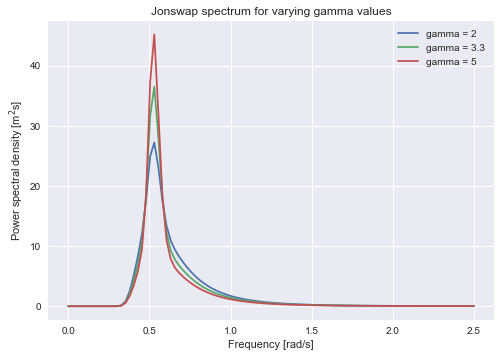

In [2]:
frequency_range = np.linspace(0, 2.5, num=100)
delta_frequency = np.diff(frequency_range)[0]
gamma_values = [2, 3.3, 5]
hs_target = 10
peak_period = 12
fig = plt.figure()

# loop over the gamma values and create a plot for each of them. Check it the expected hs corresponds to the target hs
for gamma in gamma_values:
    psd = spectrum_jonswap(omega=frequency_range, Hs=hs_target, Tp=peak_period, gamma=gamma)
    hs = 4 * np.sqrt(psd.sum() * delta_frequency)
    print("hs from spectrum {:8.3f} m".format(hs))
    plt.plot(frequency_range, psd, label="gamma = {}".format(gamma))
plt.xlabel("Frequency [rad/s]")
plt.ylabel(r"Power spectral density [m$^2$s]")
plt.legend()
plt.title("Jonswap spectrum for varying gamma values")
plt.show()

A version key can be passed to the Jonswap function. It selects the jonswap spectrum as defined in DNV (spectral_version="dnv") and the spectrum as defined in the matlab code used at HMC (spectral_version="hmc"). The difference is neglicable, as you can see below. The only reason that the version=1 was implemented was to ensure that the Matlab and Python code was idententical, however, the DNV version is preferable as it has a clear reference

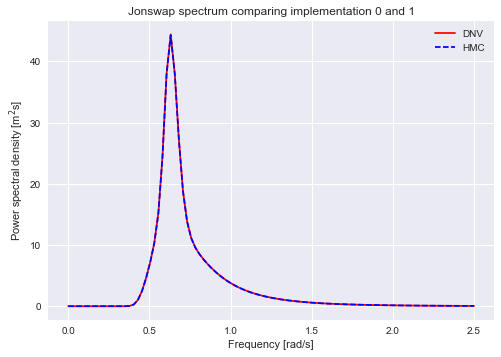

In [4]:
plt.figure()
psd_dnv = spectrum_jonswap(omega=frequency_range, Hs=12, spectral_version="dnv")
psd_hmc = spectrum_jonswap(omega=frequency_range, Hs=12,  spectral_version="hmc")
plt.plot(frequency_range, psd_dnv, '-r', label="DNV")
plt.plot(frequency_range, psd_hmc, '--b', label="HMC")
plt.xlabel("Frequency [rad/s]")
plt.ylabel(r"Power spectral density [m$^2$s]")
plt.legend()
plt.title("Jonswap spectrum comparing implementation 0 and 1")
plt.show()

In order to find the chararstic point in a spectral density we can use the `specspec` function


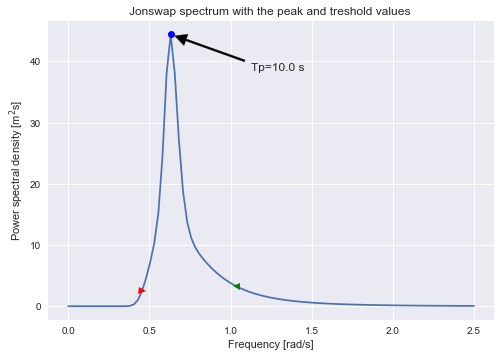

In [6]:
i_low, i_high, peak_index, f_low, f_high, f_peak, a_peak, variance = specspecs(
    frequency_range, psd_dnv, lowlim=0.01, higlim=0.9)
Tpeak = 2 * np.pi / f_peak
plt.figure()
plt.plot(frequency_range, psd_dnv)
plt.plot([f_low], [psd_dnv[i_low]], ">r")
plt.plot([f_high], [psd_dnv[i_high]], "<g")
plt.plot([f_peak], [a_peak], "ob")
plt.annotate("Tp={:.1f} s".format(Tpeak), xy=(f_peak, a_peak), xytext=(0.5,0.8), textcoords='figure fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=2))
plt.xlabel("Frequency [rad/s]")
plt.ylabel(r"Power spectral density [m$^2$s]")
plt.title("Jonswap spectrum with the peak and treshold values ")
plt.show()

The meaning of the lowlim and highlim parameters is that the energy fraction of the spectrum with frequency below f_low is 0.01 of the total, whereas the energy fraction of the spectrum with frequencies above f_high is 0.1 (1 - 0.9). We can check this:

In [7]:
energy_below_f_low = psd_dnv[:i_low + 1].sum() * delta_frequency
energy_above_f_hig = psd_dnv[i_high:].sum() * delta_frequency
energy_total = psd_dnv.sum() * delta_frequency
print("Fraction of energy below f_low={:.1f}: {:.3f}".format(f_low, energy_below_f_low / energy_total))
print("Fraction of energy above f_hig={:.1f}: {:.3f}".format(f_high, energy_above_f_hig / energy_total))

Fraction of energy below f_low=0.5: 0.011
Fraction of energy above f_hig=1.0: 0.104


Indeed the fractions of energy are with 10% given by the requested fraction of 0.01 and 0.1. Note that for the energy below we add one to
the index in order to include the boundary as well

## Spreading function

Also for the spreading function a DNV and HMC implementation was done. 

In [8]:
plt.figure()
direction_range = np.linspace(0, 2 * pi, endpoint=True, num=100)
lines = [("-r", "--g"), ("-b", "--c"), ("-k", "--y")]
for i, s in enumerate([3, 5, 13]):
    spreading_dnv = spreading_function(theta=direction_range, theta0=pi, s_spreading_factor=s)
    spreading_hmc = spreading_function2(theta=direction_range, theta0=pi, s_spreading_factor=s)
    plt.plot(direction_range, spreading_dnv, lines[i][0], label="DNV, s={}".format(s))
    plt.plot(direction_range, spreading_hmc, lines[i][1], label="HMC, s={}".format(s))
    
plt.xlabel("Direction [rad]")
plt.ylabel(r"Spreading [-]")
plt.legend()
plt.title("Spreading function DNV vs HMC")
plt.show()

Note that the solid and dashed lines should be compared as they represent the DNV and HMC implementation. The advantage of using the DNV implementation is that a numerical overflow of the Gamma function is prevented by calculating the logarithm of the spreading function internally and return the exponential of this logarigthm. This allows to take the spreading factor n arbitrary large and thus to approach a spike spreading function. The HMC implementation in `spreading_function2` would generate an overflow error for the black line with n = 100. This is demonstrated below where the spreading factor is varied upto n = 100

In [9]:
for i, s in enumerate([40, 80, 200]):
    spreading_dnv = spreading_function(theta=direction_range, theta0=pi, s_spreading_factor=s)
    plt.semilogy(direction_range, spreading_dnv, lines[i][0], label="DNV, s={}".format(s))
    try:
        spreading_hmc = spreading_function2(theta=direction_range, theta0=pi, s_spreading_factor=s)
    except OverflowError:
        print("Can not calculate the spreading function for HMC with s = {}".format(s))
    else:
        plt.semilogy(direction_range, spreading_hmc, lines[i][1], label="HMC, s={}".format(s))
    
plt.xlabel("Direction [deg]")
plt.ylabel(r"Spreading [-]")
plt.ylim(1e-2,10)
plt.xlim(0.5 * pi, 1.5 * pi)
plt.xticks([pi/2, pi, 3*pi/2], [90, 180, 270])
plt.legend()
plt.title("Spreading function DNV vs HMC")
plt.show()

Can not calculate the spreading function for HMC with s = 200


As you can see, the plotting of the most narrow distribution with s=200 failed for spreading_function2 due to a OverFlowError which was caught by an exception, whereas the spreading_function is able to plot all distributions. 

### Finding Properties of a distribution function with `thetaspreadspecs`

In this example it will be demonstrated how we can find some properties in a spectral distribution

In [14]:
spreading = spreading_function(theta=direction_range, theta0=pi)
(i_low, i_high, theta_low, theta_high, theta_peak, D_peak, area, mask) = \
 thetaspreadspecs(theta=direction_range, Dspread=spreading, areafraction=0.99)

print("i_low = {}  i_high = {}  theta_low = {:.1f} theta_high = {:.1f} theta_peak = {:.1f}".format(i_low, i_high, theta_low, theta_high, theta_peak))
print("check if area is one : {}".format(area))
print("size {} {}".format(direction_range.shape, spreading.shape))

i_low = 29  i_high = 69  theta_low = 1.8 theta_high = 4.4 theta_peak = 3.1
check if area is one : 0.9999949120079391
size (100,) (100,)


The fraction of the directional distribution between the angle theta_low and theta_high is 0.99. We can check this:


In [15]:
fraction_between_limimts = spreading[i_low:i_high].sum() / spreading.sum()
print("Fraction of distribution functions between limits {:.1f} rad/s - {:.1f} rad/s: {:.3f}"
      "".format(theta_low, theta_high, fraction_between_limimts))

Fraction of distribution functions between limits 1.8 rad/s - 4.4 rad/s: 0.987



The key points of the spreading function can now be plotted as


In [16]:
plt.figure()
plt.plot(direction_range, spreading)
plt.plot([theta_low], [spreading[i_low]], ">r")
plt.plot([theta_high], [spreading[i_high]], "<g")
plt.plot([theta_peak], [D_peak], "ob")
plt.show()

Note that the periodicity is taken into account, so for a shifted version of the distribution we would get

In [17]:
spreading = spreading_function(theta=direction_range, theta0=.2)
(i_low, i_high, theta_low, theta_high, theta_peak, D_peak, area, mask) = \
    thetaspreadspecs(theta=direction_range, Dspread=spreading)
print("i_low = {}  i_high = {}  theta_low = {:.1f} theta_high = {:.1f} theta_peak = {:.1f}"
      "".format(i_low, i_high, theta_low, theta_high, theta_peak))
print("check if area is one : {}".format(area))
print("size {} {}".format(direction_range.shape, spreading.shape))

i_low = 82  i_high = 24  theta_low = 5.2 theta_high = 1.5 theta_peak = 0.2
check if area is one : 1.0388125381306652
size (100,) (100,)


In [18]:
plt.figure()
plt.plot(direction_range, spreading)
plt.plot([theta_low], [spreading[i_low]], ">r")
plt.plot([theta_high], [spreading[i_high]], "<g")
plt.plot([theta_peak], [D_peak], "ob")
plt.show()

## Two-dimensional spectral density

A 2D spectrum can be calculated by combining the spectral density and the spreading function

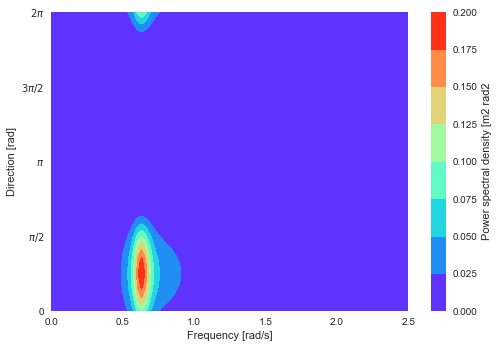

In [20]:
spec_1d = spectrum_jonswap(frequency_range)
spread_1d = spreading_function(direction_range, theta0=pi/4)

ff_2d, dd_2d = np.meshgrid(frequency_range, direction_range, indexing="ij")
spec_2d, spread_2d = np.meshgrid(spec_1d, spread_1d, indexing="ij")
spectrum_2d = spec_2d * spread_2d   

fig, ax = plt.subplots(nrows=1, ncols=1)
contourplot = ax.contourf(ff_2d, dd_2d, spectrum_2d, cmap=plt.cm.rainbow)
cb = plt.colorbar(contourplot)
cb.ax.set_ylabel("Power spectral density [m2 rad2")
plt.xlabel("Frequency [rad/s]")
plt.ylabel("Direction [rad]")
ax.set_yticks([0, pi/2, pi, 3*pi/2, 2*pi])
ax.set_yticklabels(["0", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])
plt.show()

We can also make a polar plot if we want. It is also demonstrated how you can replace the frequency labels with their equivalent periods


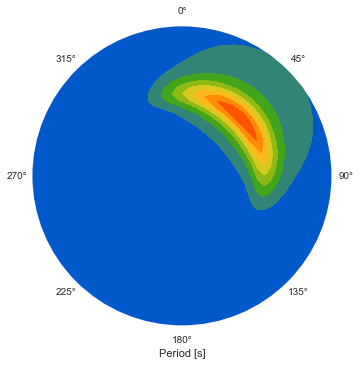

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection="polar"))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xlabel("Period [s]")
ax.set_ylabel("")
Tp_min = 7.0
Tp_max = 20.0
ax.set_ylim(2 * np.pi / Tp_max, 2 * np.pi / Tp_min) 
Tp_max = 20.0
ax.set_rlabel_position(180)

# this section is only needed to change the frequency axis ticks with the equivalent period values
new_labels = list()
label_values = list()
for label in ax.get_yticks():
    try:
        new_labels.append("{:.1f}".format(2 * np.pi / float(label)))
        label_values.append(label)
    except (ValueError, ZeroDivisionError):
        pass
ax.set_yticks(label_values)
ax.set_yticklabels(new_labels)

cs = ax.contourf(dd_2d, ff_2d, spectrum_2d, cmap=cc.m_rainbow)
plt.show()

Note that we have used the colorcet color map this time (https://github.com/bokeh/colorcet) which yields a set of perceptually uniform colormaps for Python. 